### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta


try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    
    
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')    

**Выведем основную информацию для датафреймов с помощью метода `info()`**

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


**Пропусков в данный нет**

Проверим на явные дубликаты:

In [5]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


**Явных дубликатов нет**

Переименуем столбцы:

In [6]:
visits = visits.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Session Start':'session_start','Channel':'channel','Session End':'session_end'})
orders = orders.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})
costs = costs.rename(columns={'Channel':'channel'})


Приведем столбцы с датой и временем к типу datetime:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Функция get_profiles():**

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


**Функция get_retention():**

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция get_conversion():**

In [10]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция get_ltv():**

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функция filter_data():**

In [12]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция plot_retention():**

In [13]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()



**Функция plot_conversion():**

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция plot_ltv_roi:**

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

**Составим профили пользователей:**

In [16]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


**Определим минимальную и максимальную даты привлечения пользователей:**

In [17]:
# считаем минимальную привлечения
min_date = profiles['dt'].min()

# задаём момент и горизонт анализа данных
observation_date = profiles['dt'].max()
horizon_days = 14

# считаем максимальную дату привлечения
max_date =  observation_date - timedelta(days=horizon_days - 1) 

print(f'Минимальная дата привлечения пользователей: {min_date}')
print(f'Максимальная дата привлечения пользователей: {max_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-14


**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:**

In [18]:
most_payer_region =  (profiles
           .pivot_table(
                        index='region',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
most_payer_region['payer_fate'] = round(most_payer_region['payer']/ most_payer_region['not_payer']*100,2)
most_payer_region

payer,not_payer,payer,payer_fate
region,,,
United States,93100,6902,7.41
UK,16875,700,4.15
France,16787,663,3.95
Germany,14365,616,4.29


Пользоваители приходят в приложение из США, Великобритании, Франции и Германии. Больше всего платящих пользователей приходится на США

**Узнайтем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:**

In [19]:
devices =  (profiles
           .pivot_table(
                        index='device',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
devices['payer_fate'] = round(devices['payer']/ devices['not_payer']*100,2)
devices

payer,not_payer,payer,payer_fate
device,,,
iPhone,51097,3382,6.62
Android,32982,2050,6.22
Mac,28130,1912,6.80
PC,28918,1537,5.32


Клиенты пользуются устройствами - iPhone, Android, Mac и PC. Платящие пользователи больше всего предпочитают iPhone.

**Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей:**

In [20]:
ad_channel =  (profiles
           .pivot_table(
                        index='channel',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
ad_channel['payer_fate'] = round(ad_channel['payer']/ ad_channel['not_payer']*100,2)
ad_channel

payer,not_payer,payer,payer_fate
channel,,,
FaceBoom,25587,3557,13.90
TipTop,17683,1878,10.62
organic,55279,1160,2.10
WahooNetBanner,8100,453,5.59
AdNonSense,3440,440,12.79
RocketSuperAds,4096,352,8.59
LeapBob,8291,262,3.16
OppleCreativeMedia,8372,233,2.78
lambdaMediaAds,1924,225,11.69


Для привлечения пользователей используются 10 реколамных каналов и также много пользлвателей приходит из organic.  Больше всего платящих пользователей приходят из каналов FaceBoom, TipTop и AdNonSense.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

**Посчитаем общую сумму расходов на маркетинг:**

In [21]:
marketing_total = costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг: {marketing_total.round()}')

Общая сумма расходов на маркетинг: 105497.0


**Выясним сколько денег потратили на каждый источник:**

In [22]:
ad_channel_cost = (costs.pivot_table(
                        index='channel',
                        values='costs',
                        aggfunc='sum')
                        .sort_values(by='costs', ascending=False)) 
           
ad_channel_cost['percent'] = round(ad_channel_cost['costs'] / marketing_total*100,2)
ad_channel_cost

,costs,percent
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


**Построим визуализацию динамики изменения расходов во времени по неделям по каждому источнику:**

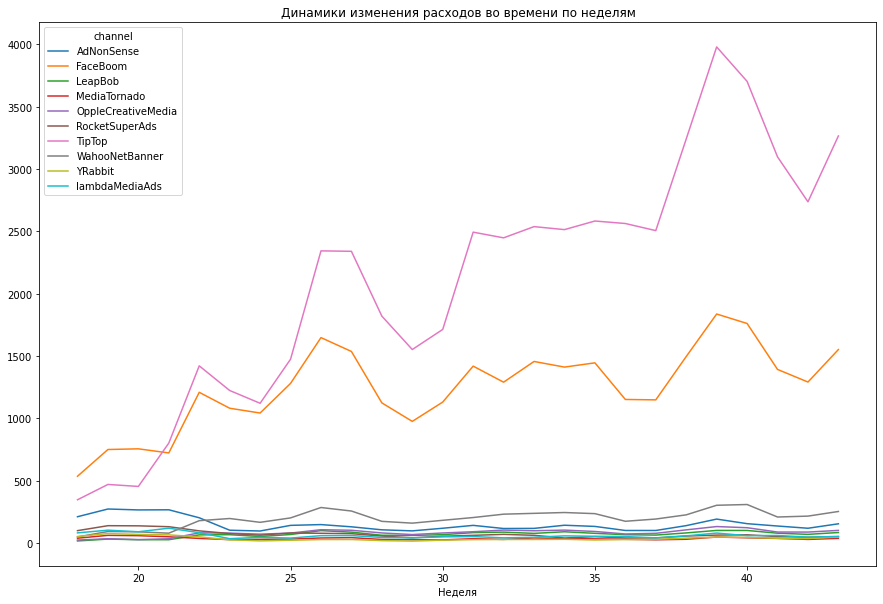

In [23]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

costs.pivot_table(
    index='week',
    values='costs',
    aggfunc='sum',
    columns='channel').plot(figsize=(15, 10))

plt.xlabel('Неделя')
plt.title('Динамики изменения расходов во времени по неделям')
plt.show()

**Построим визуализацию динамики изменения расходов во времени по месяцам по каждому источнику:**

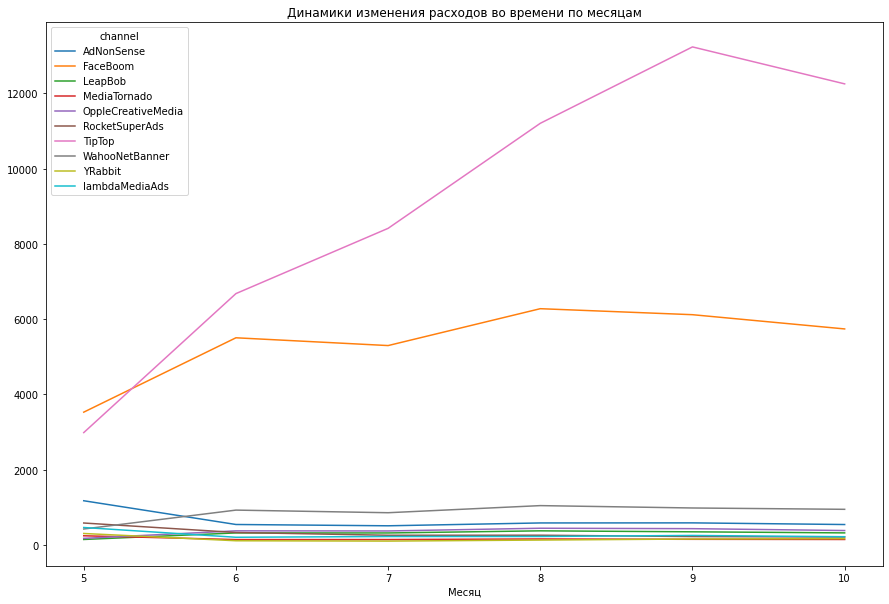

In [24]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.pivot_table(
    index='month',
    values='costs',
    aggfunc='sum',
    columns='channel').plot(figsize=(15, 10))

plt.xlabel('Месяц')
plt.title('Динамики изменения расходов во времени по месяцам')
plt.show()

**Узнаем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника:**

In [25]:
profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

**Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI:**

Исколючим канал organic так как стомость привлечения пользователей из него равно 0:

In [26]:
profiles = profiles.query('channel != "organic"')

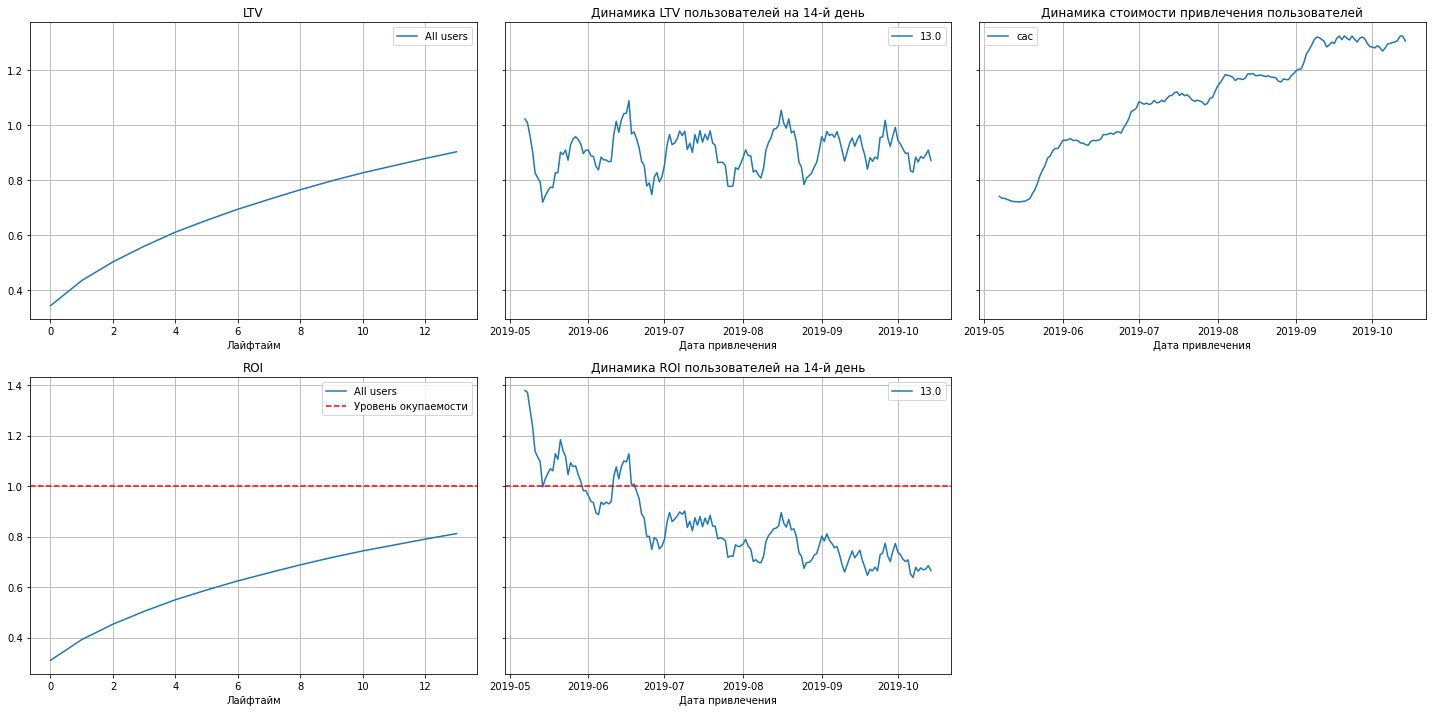

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


- Стоимость привлечения новых пользователей(CAC) постоянно растет.
- На 14 день привлеченные пользователи не окупаются.
- Пользователи перестали окупаться с июня месяца.

**Проверим конверсию пользователей и динамику её изменения, постройроим и изучим график:**

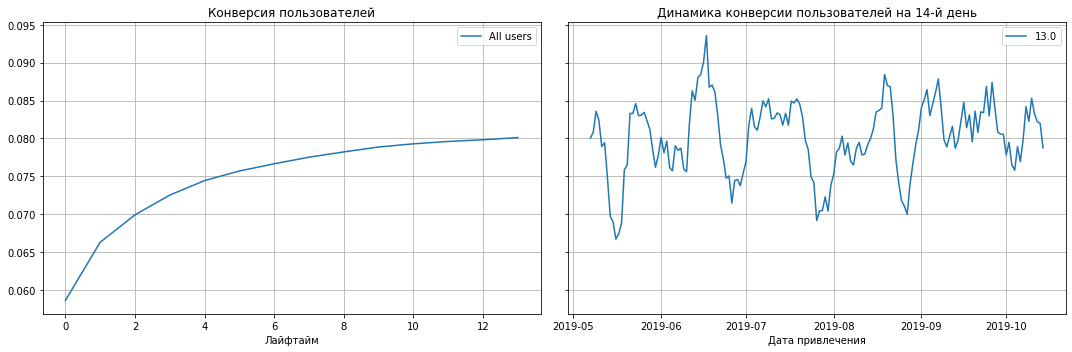

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По устройствам:

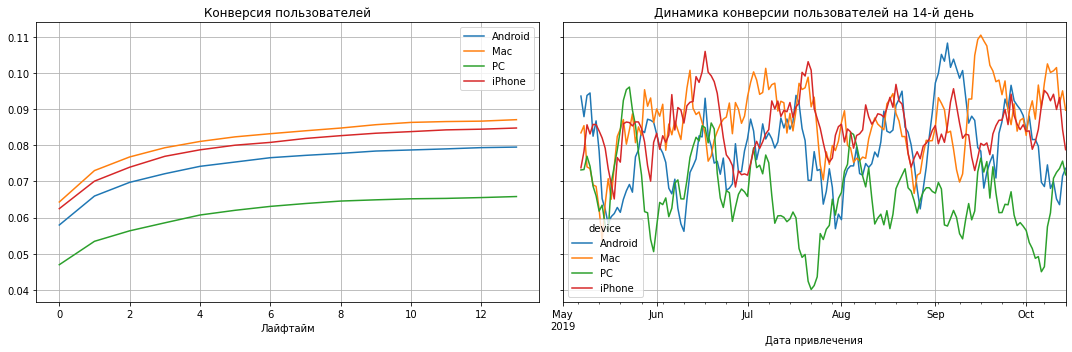

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По региону:

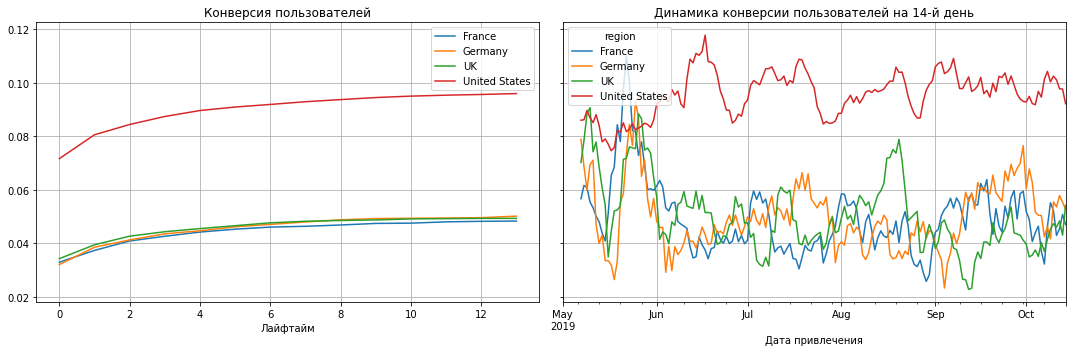

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По рекламным каналам:

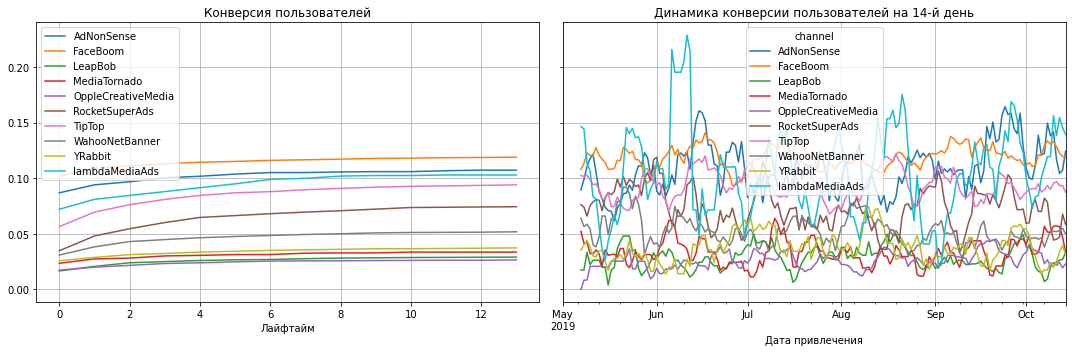

In [44]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Проверим удержание пользователей, постройроим и изучим график:**

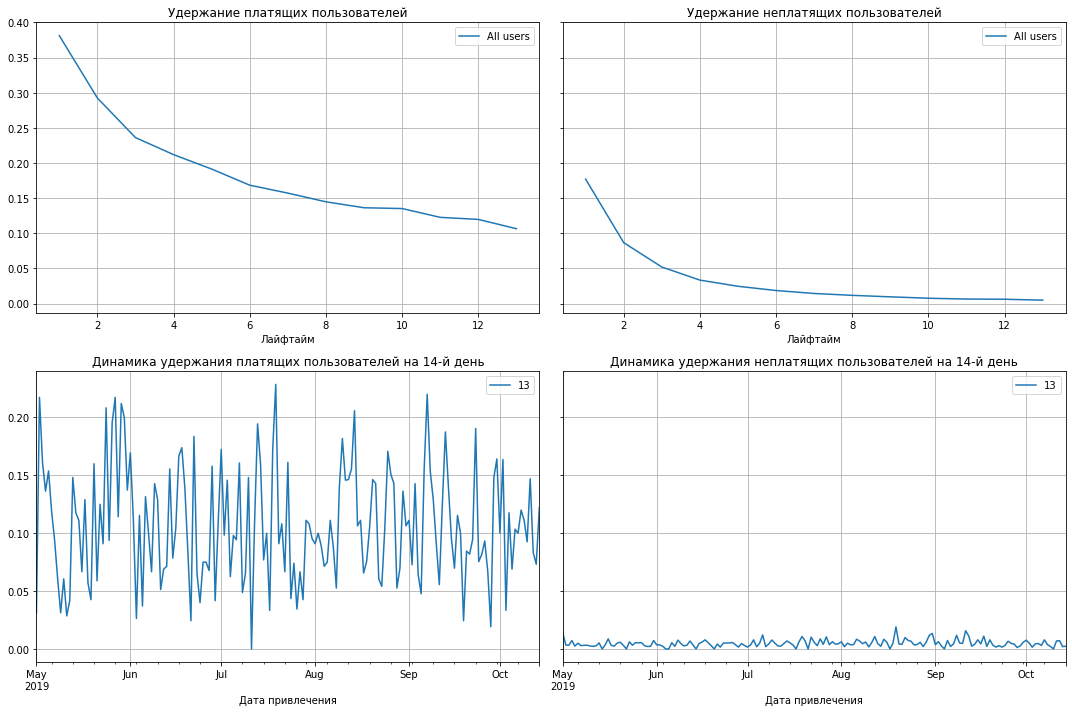

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)
plot_retention(retention_grouped, retention_history, horizon_days)

По устройствам:

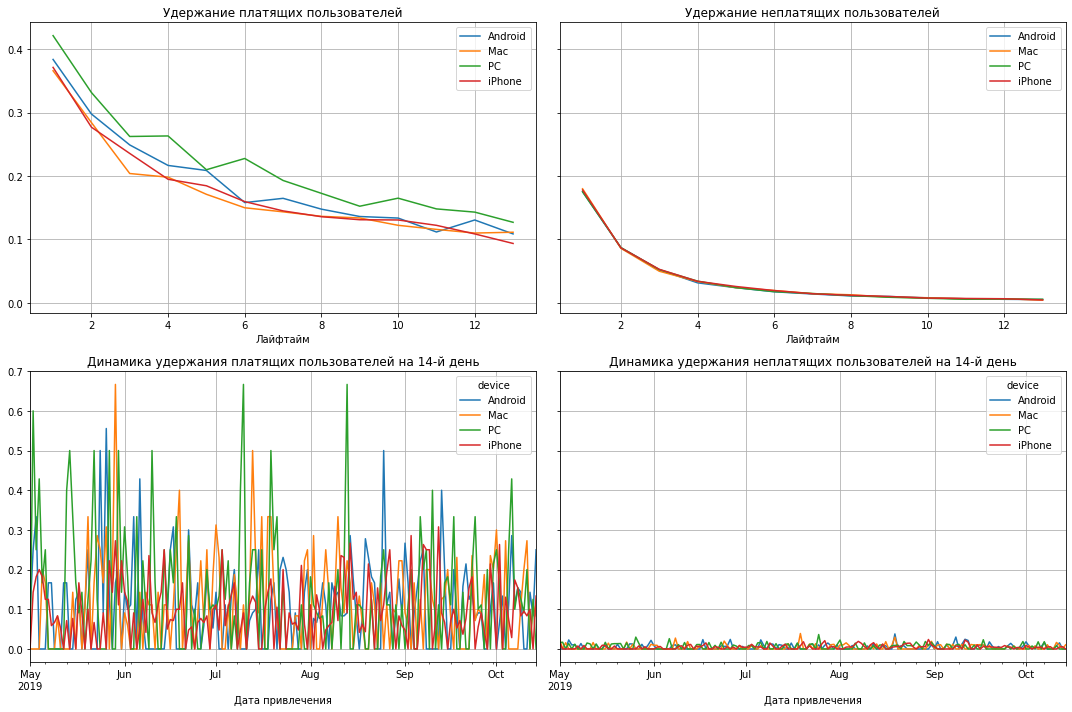

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['device']
)
plot_retention(retention_grouped, retention_history, horizon_days)

По региону:

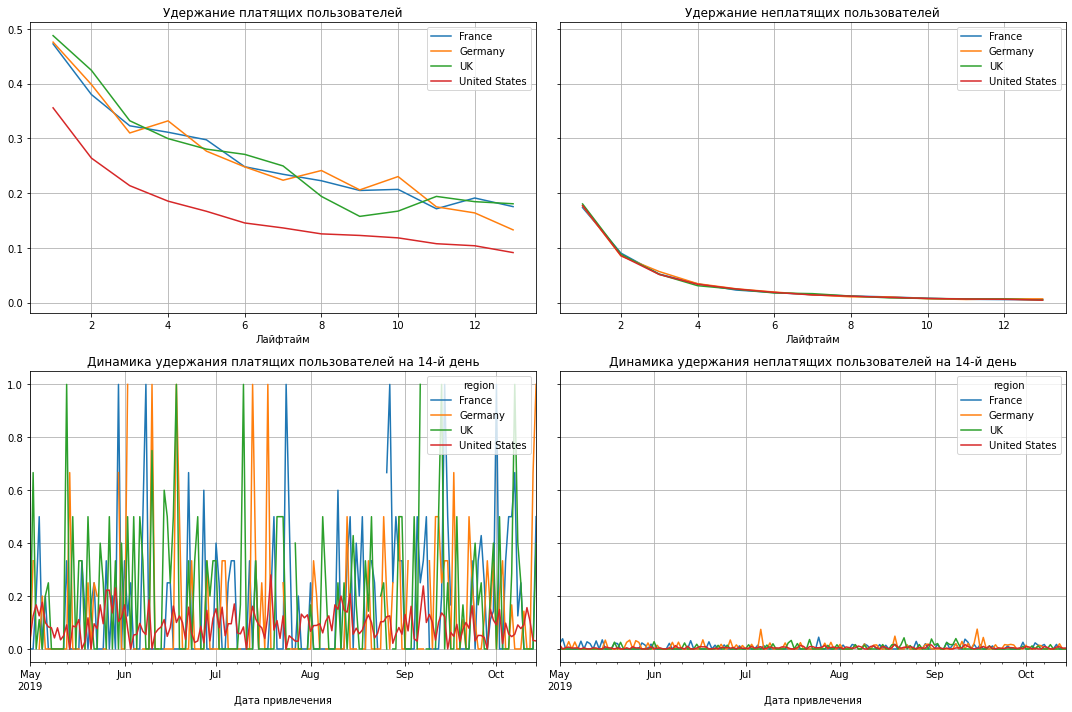

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['region']
)
plot_retention(retention_grouped, retention_history, horizon_days)

По рекламным каналам:

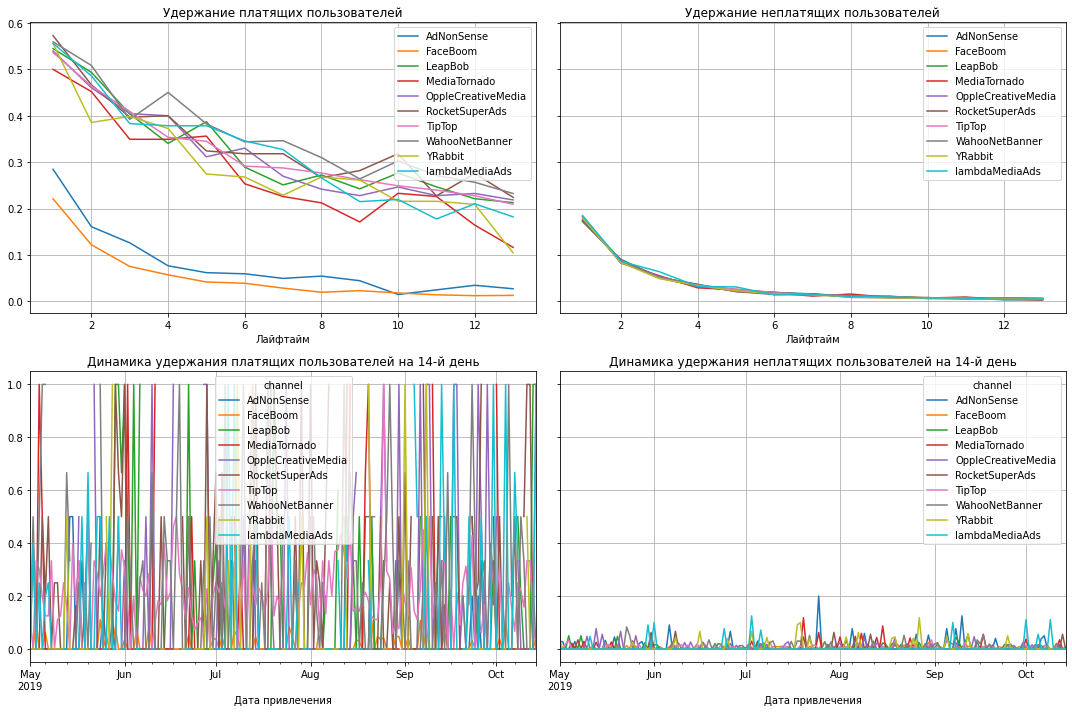

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['channel']
)
plot_retention(retention_grouped, retention_history, horizon_days)

**Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI:**

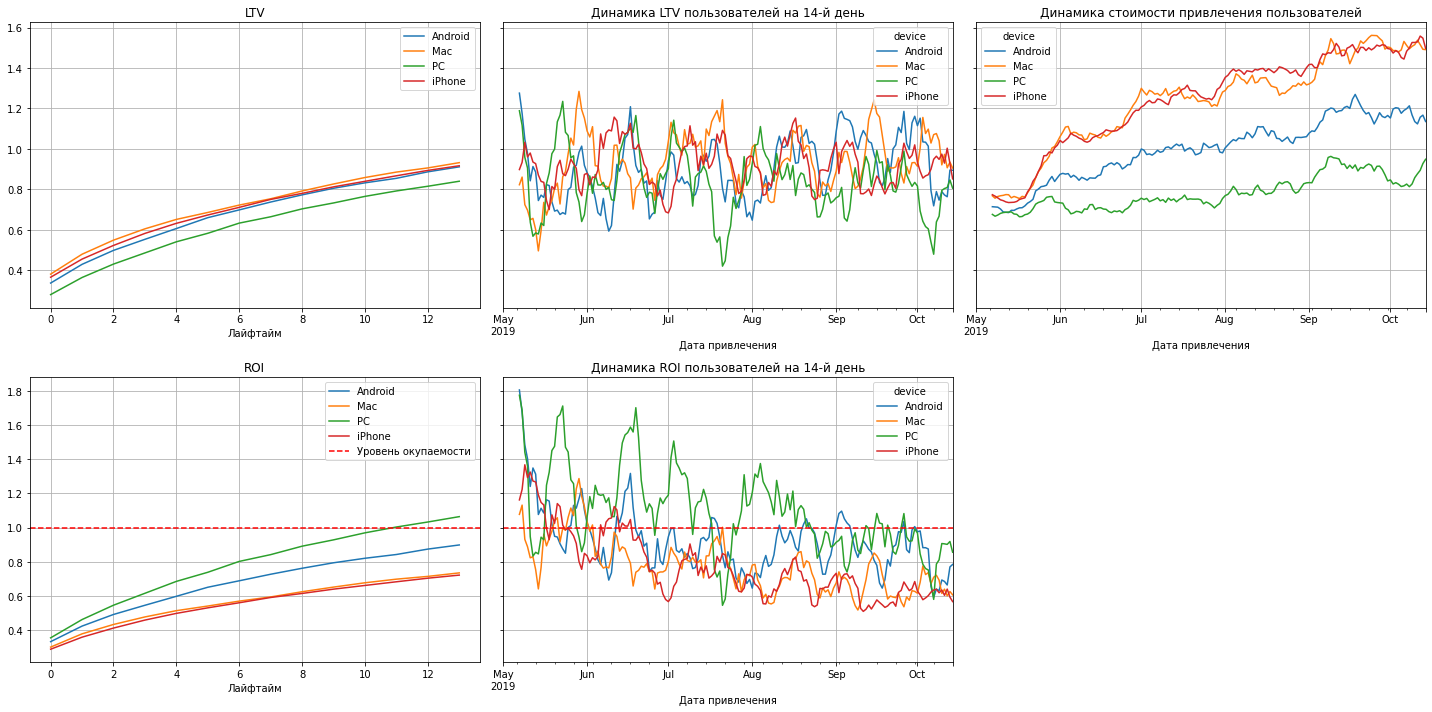

In [37]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['device']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

 - Реклама окупается только на платформе PC
 - Стоимость привлечения пользователей постоянно растет. Самое дешевое привлечение идет на платформе PC, самое дорогое на Mac и iPhone.
 - С июня месяца резко расчет стоимость приалечение польщователей на платформах Mac и iPhone.

**Проанализируем окупаемость рекламы с разбивкой по странам:**

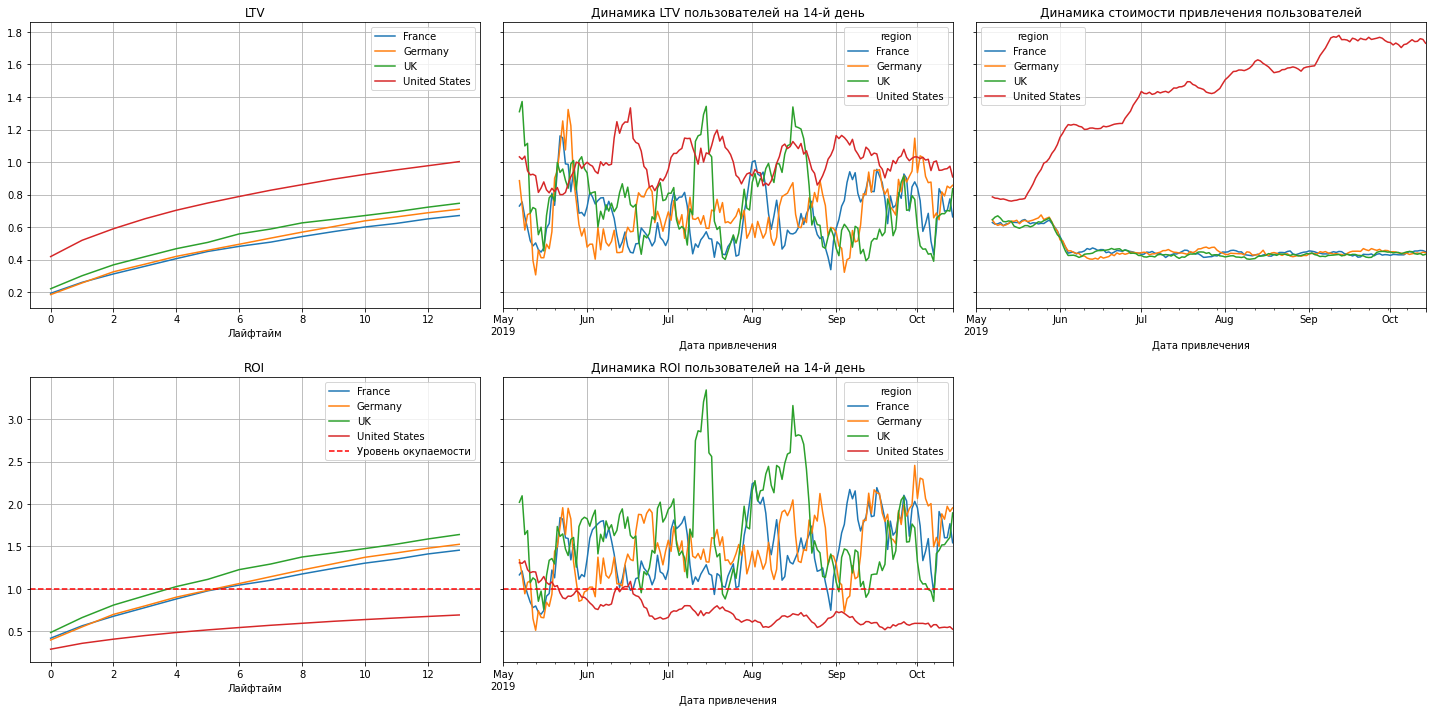

In [38]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['region']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- Окупаются пользователи из Франции, Германии и Великобритании. Стоимость их привлемения примерно равна.
- Пользоватери из США не окупаются, и стоимость их привлесения максимальная.


**Проанализируем окупаемость рекламы с разбивкой по рекламным каналам:** 

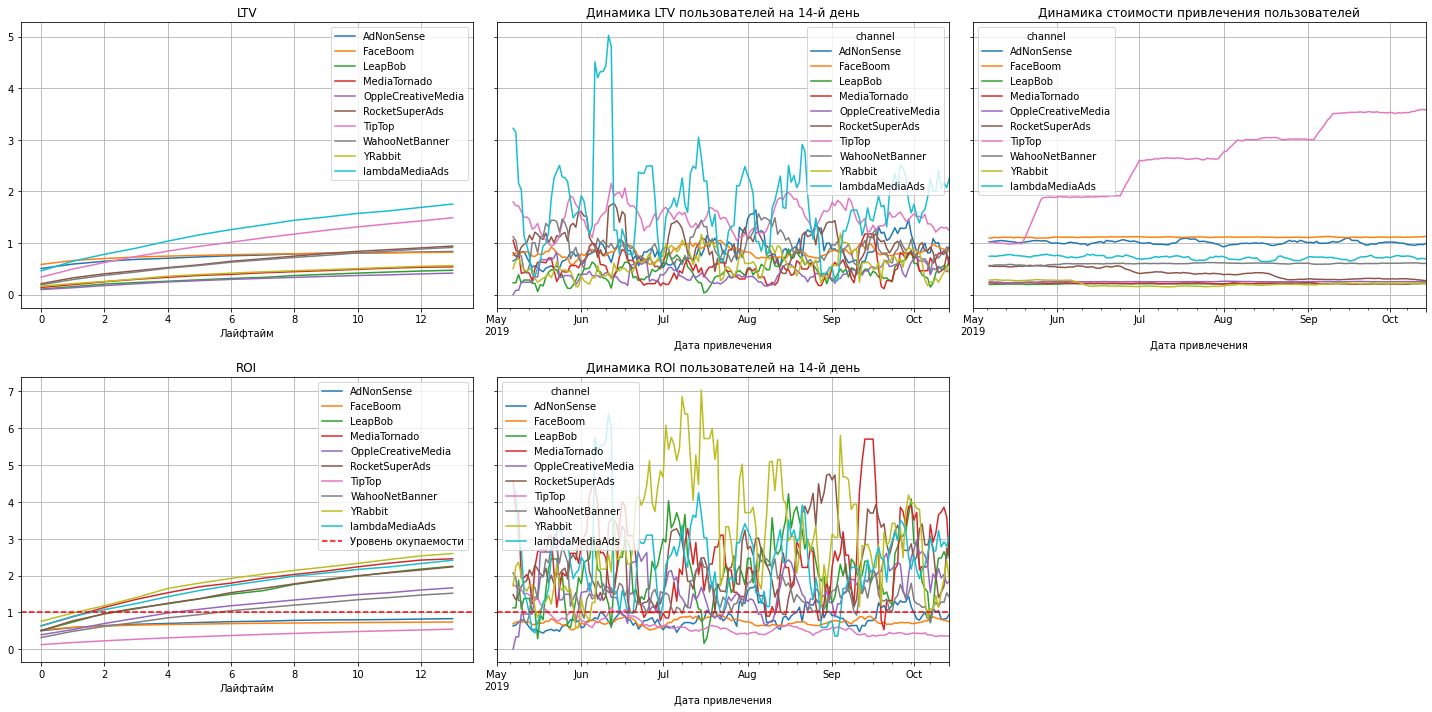

In [40]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- Не окупаются 3 рекламных канала - TipTop, FaceBoom и AdNonSense, при этом на них уходит более 35% рекламного бютжета.
- Стоимость привлечения пользователей по каналу TipTop постоянно ощутимо расчет.
- Самым интересным каналом приалечения является lambdaMediaAds, средняя стоимость привлечения, лучший LTV и один из лучших ROI.

- Реклама вцелом не окупается.
- Устройства которые оказывают негативное влияние на окупаемость рекламы - Mac, iPhone, страна - США, рекламные каналы - TipTop, FaceBoom и AdNonSense.
- Проблемы окупаемости могут быть вызваны высокой стоимостью привлечения пользователей на некоторых рекламных площадках, низким удерданием платящих пользователей из США, не верного выбора устройств для рекламы.


### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Причины неэффективности привлечения пользователей:**
 - Высокая стоимоить привлечения пользователей рекламных каналов TipTop, FaceBoom и AdNonSense, которые не окупаются. Очень слабое удердание пользователей каналов FaceBoom и AdNonSense.
 - Слабое удержание платящих пользоватеоей из США и самая высокая стоимость их привлечения.
 - Очень большой рост с июня стоимости привлечения из канала TipTop.

**Рекомендации для отдела маркетинга:**
1. Отказаться от рекламного канала TipTop, перераспределить бютжет на более перспективный канал, например lambdaMediaAds.
2. Разобраться с удержанием платящих пользователей каналов FaceBoom и AdNonSense. Если удержание повысить невозможно, то отказаться от них.
3. Разобраться с удержанием платящих пользователей из США, возможно продукт не подходит под их рынок. Если это не так, то перейти на более дешевые каналы привлечения пользователей.
4. Попробовать перераспределить рекламные бютжеты больше на платформы PC и Androd чем на Mac и iPhone.
5. Перераспределить бютжет больше на Европу и Великобританию, чем на США.
